Accuracy: 0.8627450980392157


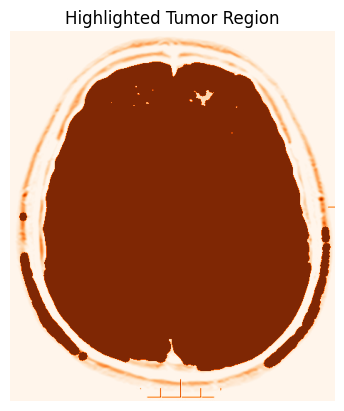

In [1]:
import fuzzycmeans as fcm#main
from skimage import io, color
import numpy as np
from skimage.morphology import disk, opening
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the image
filename = '/home/harshk/LLM/llm_apps/jinx/h.jpg'  # Provide the path to your image
I = io.imread(filename)

# Check if the image is grayscale
if len(I.shape) == 3 and I.shape[2] == 3:
    # Convert RGB image to grayscale
    I = color.rgb2gray(I)

# Define the number of clusters (2 for brain and tumor)
num_clusters = 2

# Reshape the image to a 1D array (feature vector)
num_pixels = I.size
feature_vector = I.reshape(num_pixels, 1)

# Fuzzy C-Means clustering
fcm_instance = fcm.FCM(n_clusters=num_clusters)
fcm_instance.fit(feature_vector)

# Get the membership matrix
u = fcm_instance.u

# Determine the cluster for each pixel
idx = np.argmax(u, axis=1)
segmented_image = idx.reshape(I.shape)

# Create a mask for the tumor region
tumor_mask = segmented_image == 1  # Assuming tumor is cluster 1

# Apply morphological operations to further refine the tumor region
se = disk(5)  # Define a disk-shaped structuring element
tumor_mask = opening(tumor_mask, se)  # Perform morphological opening

# Extract features from the tumor region for classification
tumor_features = []
for filename in os.listdir(r'/home/harshk/LLM/llm_apps/jinx/yes'):
    img_path = os.path.join(r'/home/harshk/LLM/llm_apps/jinx/yes', filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    img = cv2.medianBlur(img, 3)  # Apply median filter to remove noise
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]  # Apply Otsu thresholding
    # Resize image to a consistent size (e.g., 100x100)
    img = cv2.resize(img, (100, 100))
    # Check if the shape of the feature vector is consistent
    if img.flatten().shape[0] == 100 * 100:
        tumor_features.append(img.flatten())
    else:
        print(f"Ignoring {filename}: Inconsistent feature vector shape")

# Similarly, extract features from the non-tumor region for classification
non_tumor_features = []
for filename in os.listdir(r'/home/harshk/LLM/llm_apps/jinx/no'):
    img_path = os.path.join(r'/home/harshk/LLM/llm_apps/jinx/no', filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    img = cv2.medianBlur(img, 3)  # Apply median filter to remove noise
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]  # Apply Otsu thresholding
    # Resize image to a consistent size (e.g., 100x100)
    img = cv2.resize(img, (100, 100))
    # Check if the shape of the feature vector is consistent
    if img.flatten().shape[0] == 100 * 100:
        non_tumor_features.append(img.flatten())
    else:
        print(f"Ignoring {filename}: Inconsistent feature vector shape")

# Combine features and labels
X = np.vstack((tumor_features, non_tumor_features))
y = np.concatenate((np.ones(len(tumor_features)), np.zeros(len(non_tumor_features))))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Support Vector Machine (SVM) model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Apply tumor mask to original image
highlighted_image = np.copy(I)
highlighted_image[tumor_mask] = 1  # Highlight tumor region

# Display the highlighted image
plt.imshow(highlighted_image, cmap='Oranges')
plt.title('Highlighted Tumor Region')
plt.axis('off')
plt.show()